In [4]:
from collections import defaultdict
from io import BytesIO as StringIO
from itertools import chain
from mock import patch
import os
import unittest

from apriori import (
    getItemSetTransactionList,
    dataFromFile,
    joinSet,
    printResults,
    returnItemsWithMinSupport,
    runApriori,
    subsets,
)


class AprioriTest(unittest.TestCase):
    def test_subsets_should_return_empty_subsets_if_input_empty_set(self):
        result = tuple(subsets(frozenset([])))

        self.assertEqual(result, ())

    def test_subsets_should_return_non_empty_subsets(self):
        result = tuple(subsets(frozenset(['beer', 'rice'])))

        self.assertEqual(result[0], ('beer',))
        self.assertEqual(result[1], ('rice',))
        self.assertEqual(result[2], ('beer', 'rice',))

    def test_return_items_with_min_support(self):
        itemSet = set([
            frozenset(['apple']),
            frozenset(['beer']),
            frozenset(['chicken']),
            frozenset(['mango']),
            frozenset(['milk']),
            frozenset(['rice'])
        ])
        transactionList = [
            frozenset(['beer', 'rice', 'apple', 'chicken']),
            frozenset(['beer', 'rice', 'apple']),
            frozenset(['beer', 'apple']),
            frozenset(['mango', 'apple']),
            frozenset(['beer', 'rice', 'milk', 'chicken']),
            frozenset(['beer', 'rice', 'milk']),
            frozenset(['beer', 'milk']),
            frozenset(['mango', 'milk'])
        ]
        minSupport = 0.5
        freqSet = defaultdict(int)

        result = returnItemsWithMinSupport(
            itemSet,
            transactionList,
            minSupport,
            freqSet
        )

        expected = set([
            frozenset(['milk']),
            frozenset(['apple']),
            frozenset(['beer']),
            frozenset(['rice'])
        ])
        self.assertEqual(result, expected)

        expected = defaultdict(
            int,
            {
                frozenset(['apple']): 4,
                frozenset(['beer']): 6,
                frozenset(['chicken']): 2,
                frozenset(['mango']): 2,
                frozenset(['milk']): 4,
                frozenset(['rice']): 4
            }
        )
        self.assertEqual(freqSet, expected)

    def test_join_set_and_get_two_element_itemsets(self):
        itemSet = set([
            frozenset(['apple']),
            frozenset(['beer']),
            frozenset(['chicken']),
            frozenset(['mango']),
            frozenset(['milk']),
            frozenset(['rice'])
        ])

        result = joinSet(itemSet, 2)

        expected = set([
            frozenset(['chicken', 'mango']),
            frozenset(['rice', 'apple']),
            frozenset(['beer', 'apple']),
            frozenset(['rice', 'milk']),
            frozenset(['beer', 'rice']),
            frozenset(['chicken', 'apple']),
            frozenset(['beer', 'milk']),
            frozenset(['chicken', 'rice']),
            frozenset(['beer', 'mango']),
            frozenset(['beer', 'chicken']),
            frozenset(['apple', 'milk']),
            frozenset(['mango', 'milk']),
            frozenset(['mango', 'apple']),
            frozenset(['rice', 'mango']),
            frozenset(['chicken', 'milk'])
        ])
        self.assertEqual(result, expected)

    def test_join_set_and_get_three_element_itemsets(self):
        itemSet = set([
            frozenset(['apple', 'beer']),
            frozenset(['beer']),
            frozenset(['chicken']),
            frozenset(['mango']),
            frozenset(['milk']),
            frozenset(['rice'])
        ])

        result = joinSet(itemSet, 3)

        expected = set([
            frozenset(['beer', 'mango', 'apple']),
            frozenset(['beer', 'apple', 'chicken']),
            frozenset(['beer', 'apple', 'milk']),
            frozenset(['beer', 'rice', 'apple'])
        ])
        self.assertEqual(result, expected)

    def test_get_itemset_and_transaction_list_from_data_iterator(self):
        data_iterator = [
            frozenset(['beer', 'rice', 'apple', 'chicken']),
            frozenset(['mango', 'beer']),
        ]

        itemSet, transactionList = getItemSetTransactionList(data_iterator)

        expected = set([
            frozenset(['chicken']),
            frozenset(['apple']),
            frozenset(['beer']),
            frozenset(['rice']),
            frozenset(['mango'])
        ])
        self.assertEqual(itemSet, expected)

        expected = data_iterator
        self.assertEqual(transactionList, expected)

    def test_read_data_from_file(self):
        os.system('echo \'apple,beer,rice\' > test_apriori.csv')

        result = dataFromFile('test_apriori.csv')
        data = [each for each in result]

        expected = frozenset(['beer', 'rice', 'apple'])
        self.assertEqual(data[0], expected)

        os.system('rm test_apriori.csv')

    def test_print_results_should_have_results_in_defined_format(self):
        with patch('sys.stdout', new=StringIO()) as fake_output:
            items = [
                (('milk',), 0.5),
                (('apple',), 0.5),
                (('beer',), 0.75),
                (('rice',), 0.5),
                (('beer', 'rice'), 0.5)
            ]
            rules = [
                ((('beer',), ('rice',)), 0.6666666666666666),
                ((('rice',), ('beer',)), 1.0)
            ]
            printResults(items, rules)

            expected = "item: ('milk',) , 0.500\nitem: ('apple',) , "
            expected += "0.500\nitem: ('rice',) , 0.500\nitem: ('beer', "
            expected += "'rice') , 0.500\nitem: ('beer',) , 0.750\n\n"
            expected += "------------------------ RULES:\nRule: ('beer',) "
            expected += "==> ('rice',) , 0.667\nRule: ('rice',) ==> "
            expected += "('beer',) , 1.000\n"
            self.assertEqual(fake_output.getvalue(), expected)

    def test_run_apriori_should_get_items_and_rules(self):
        data = 'apple,beer,rice,chicken\n'
        data += 'apple,beer,rice\n'
        data += 'apple,beer\n'
        data += 'apple,mango\n'
        data += 'milk,beer,rice,chicken\n'
        data += 'milk,beer,rice\n'
        data += 'milk,beer\n'
        data += 'milk,mango'
        os.system('echo \'' + data + '\' > test_apriori.csv')

        inFile = dataFromFile('test_apriori.csv')
        minSupport = 0.5
        minConfidence = 0.05

        items, rules = runApriori(inFile, minSupport, minConfidence)

        expected = [
            (('milk',), 0.5),
            (('apple',), 0.5),
            (('beer',), 0.75),
            (('rice',), 0.5),
            (('beer', 'rice'), 0.5)
        ]
        self.assertEqual(items, expected)

        expected = [
            ((('beer',), ('rice',)), 0.6666666666666666),
            ((('rice',), ('beer',)), 1.0)
        ]
        self.assertEqual(rules, expected)

        os.system('rm test_apriori.csv')


if __name__ == '__main__':
    unittest.main()

frozenset([5]) --> frozenset([2]) conf: 1.0
frozenset([2]) --> frozenset([5]) conf: 0.75
frozenset([6]) --> frozenset([5]) conf: 0.75
frozenset([5]) --> frozenset([6]) conf: 1.0
frozenset([6]) --> frozenset([1]) conf: 0.75
frozenset([1]) --> frozenset([6]) conf: 1.0
frozenset([6]) --> frozenset([4]) conf: 0.75
frozenset([4]) --> frozenset([6]) conf: 1.0
frozenset([3]) --> frozenset([2]) conf: 1.0
frozenset([2]) --> frozenset([3]) conf: 0.75
frozenset([6]) --> frozenset([2]) conf: 1.0
frozenset([2]) --> frozenset([6]) conf: 1.0
frozenset([2]) --> frozenset([1]) conf: 0.75
frozenset([1]) --> frozenset([2]) conf: 1.0
frozenset([6]) --> frozenset([3]) conf: 0.75
frozenset([3]) --> frozenset([6]) conf: 1.0
frozenset([4]) --> frozenset([2]) conf: 1.0
frozenset([2]) --> frozenset([4]) conf: 0.75
freqSet: frozenset([1, 2, 6])
frozenset([2, 6]) --> frozenset([1]) conf: 0.75
frozenset([1, 6]) --> frozenset([2]) conf: 1.0
frozenset([1, 2]) --> frozenset([6]) conf: 1.0
m: 1 Hmp1 now: [frozenset([1

ImportError: cannot import name getItemSetTransactionList

Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


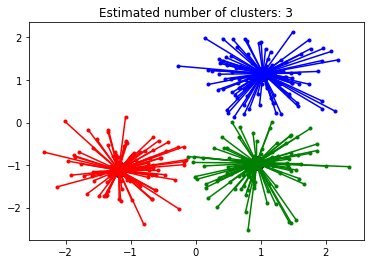

In [8]:
print(__doc__)

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Automatically created module for IPython interactive environment
Compute unstructured hierarchical clustering...
Elapsed time: 1.38s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.50s
Number of points: 1500


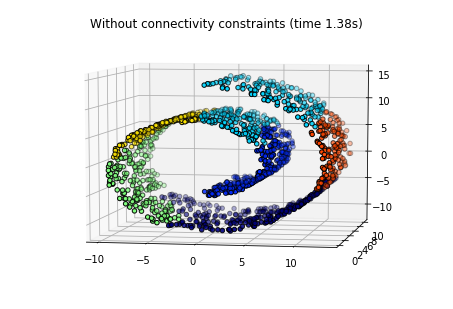

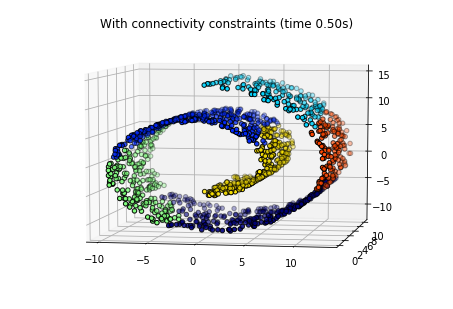

In [6]:
print(__doc__)

import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll

# #############################################################################
# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise)
# Make it thinner
X[:, 1] *= .5

# #############################################################################
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

Automatically created module for IPython interactive environment
Estimated number of clusters: 5
Homogeneity: 0.591
Completeness: 0.622
V-measure: 0.606
Adjusted Rand Index: 0.421
Adjusted Mutual Information: 0.587
Silhouette Coefficient: 0.210


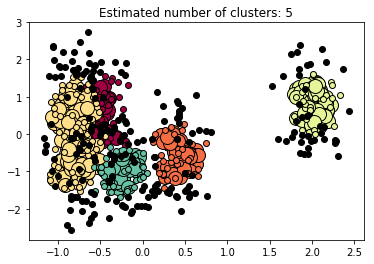

In [9]:
# DBScan 

print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1,2,3], [0.3,0.9,1], [0.2,2,1],[9,2,3],[4,1,0.5],[2,0.7,4]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.5,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [3]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=10, centers=3, n_features=2,
                  random_state=0)
print(X.shape)
y



(10, 2)


array([0, 0, 1, 0, 2, 2, 2, 1, 1, 0])